In [19]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [20]:
df = pd.read_csv('Bitcoin-2018min.csv')
df.index = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.drop(columns=['Date'], inplace=True)
df['Open'] = df['Open'].replace({',': '', '%': '', '$': ''}, regex=True)
df.sort_values(by='Date', inplace=True)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-01-01,"13,444.9",13850.5,"13,921.5","12,877.7",78.43K,-2.93%
2018-01-02,"14,754.1",13444.9,"15,306.1","12,934.2",137.73K,9.74%
2018-01-03,"15,156.6",14754.1,"15,435.0","14,579.7",106.54K,2.73%
2018-01-04,"15,180.1",15156.5,"15,408.7","14,244.7",110.97K,0.15%
2018-01-05,"16,954.8",15180.1,"17,126.9","14,832.4",141.96K,11.69%
...,...,...,...,...,...,...
2024-11-06,"75,586.3",69374.1,"76,401.4","69,323.0",357.28K,8.96%
2024-11-07,"75,868.6",75585.5,"76,837.8","74,448.2",184.16K,0.37%
2024-11-08,"76,517.3",75869.8,"77,188.5","75,599.0",155.17K,0.85%


In [21]:
print(df['Open'].dtype)
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['Open'] = df['Open'].dropna()
print(df['Open'].dtype)
temp_d = df['Open']
temp_d

object
float64


Date
2018-01-01    13850.5
2018-01-02    13444.9
2018-01-03    14754.1
2018-01-04    15156.5
2018-01-05    15180.1
               ...   
2024-11-06    69374.1
2024-11-07    75585.5
2024-11-08    75869.8
2024-11-09    76506.1
2024-11-10    76681.4
Name: Open, Length: 2506, dtype: float64

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
temp_d=scaler.fit_transform(np.array(temp_d).reshape(-1,1))
print(temp_d.shape)

(2506, 1)


In [23]:
training_size=int(len(temp_d)*0.60)
test_size=len(temp_d)-training_size
train_data, test_data = temp_d[0:training_size], temp_d[training_size:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1503, 1)
test_data:  (1003, 1)


In [24]:
# [[[1],[2],[3],[4],[5]]] [6]
# [[[2],[3],[4],[5],[6]]] [7]
# [[[3],[4],[5],[6],[7]]] [8]

def df_to_x_y(dataset, window_size=60):
    x = []
    y = []
    for i in range(len(dataset)-window_size):
        first_10 = [[a] for a in dataset[i:i+60]]
        x.append(first_10)
        nxt = dataset[i+60]
        y.append(nxt)
    return np.array(x), np.array(y)


In [25]:
WINDOW_SIZE = 60
X_train, y_train = df_to_x_y(train_data, WINDOW_SIZE)
X_test, y_test = df_to_x_y(test_data, WINDOW_SIZE)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1443, 60, 1, 1)
y_train:  (1443, 1)
X_test:  (943, 60, 1, 1)
y_test (943, 1)


In [26]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1443, 60, 1)
X_test:  (943, 60, 1)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Input(shape=(None, 1)))  
model.add(LSTM(10, activation="relu"))  

model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
cp = ModelCheckpoint('models/best_model.keras', save_best_only=True)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=[RootMeanSquaredError()]
)

In [29]:


history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1, callbacks=[cp])

Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0754 - root_mean_squared_error: 0.2745 - val_loss: 0.1365 - val_root_mean_squared_error: 0.3695
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0366 - root_mean_squared_error: 0.1892 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss

In [30]:
from tensorflow.keras.models import load_model
model = load_model('models/best_model.keras')

In [31]:
train_predictions = model.predict(X_train).flatten()
train_predictions = train_predictions.flatten()
# Reverse the scaling of the predictions and actuals: in order to see actual values instead of numbers between 0 and 1.
train_predictions_original = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Create the DataFrame with the original values
train_results_original = pd.DataFrame(data={'Train Predictions': train_predictions_original, 'Actuals': y_train_original})
train_results_original

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Train Predictions,Actuals
0,10388.458984,10904.5
1,10715.474609,10822.5
2,10801.971680,11402.8
3,11180.064453,11415.7
4,11347.459961,11314.2
...,...,...
1438,41500.093750,42385.2
1439,42522.250000,43833.9
1440,43941.394531,44038.2
1441,44438.546875,44388.9


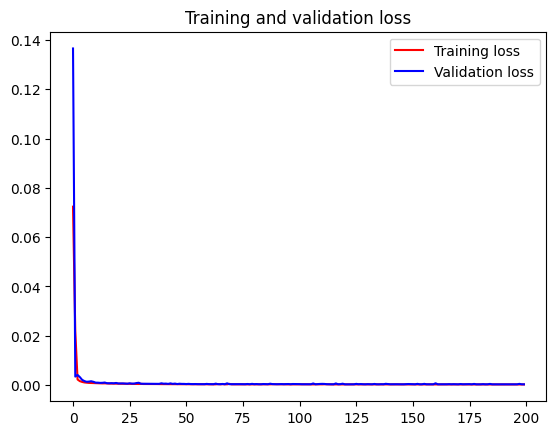

<Figure size 640x480 with 0 Axes>

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

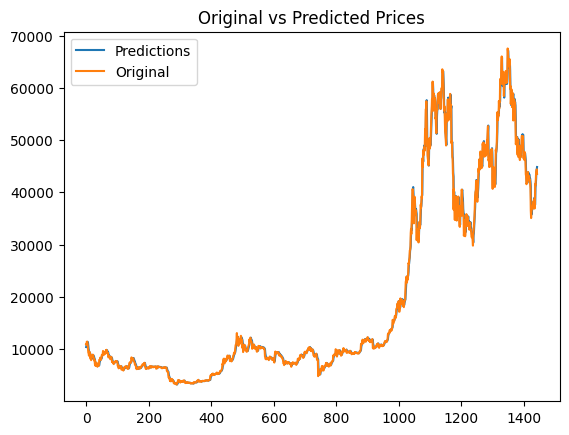

In [33]:
plt.plot(train_results_original['Train Predictions'], label='Predictions')
plt.plot(train_results_original['Actuals'], label='Original')
plt.legend(loc=0)
plt.title('Original vs Predicted Prices')
plt.show()

In [34]:
test_predictions = model.predict(X_test).flatten()
test_predictions = test_predictions.flatten()
# Reverse the scaling of the predictions and actuals: in order to see actual values instead of numbers between 0 and 1.
test_predictions_original = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create the DataFrame with the original values
test_results_original = pd.DataFrame(data={'Test Predictions': test_predictions_original, 'Actuals': y_test_original})
test_results_original

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Test Predictions,Actuals
0,40101.425781,40072.0
1,40163.367188,41133.0
2,41005.359375,39936.0
3,40221.093750,40571.0
4,40630.023438,40382.0
...,...,...
938,67221.734375,69374.1
939,68783.273438,75585.5
940,75241.968750,75869.8
941,75908.109375,76506.1


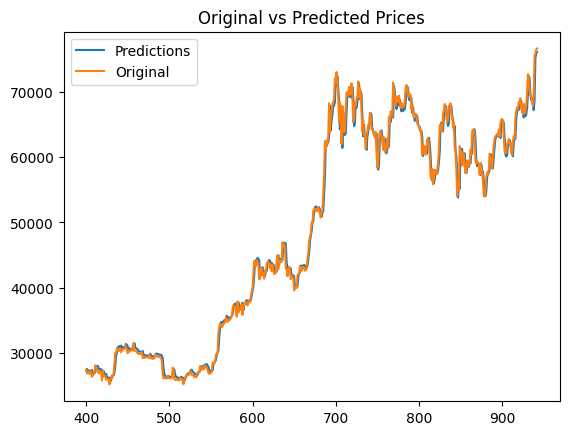

In [35]:
plt.plot(test_results_original['Test Predictions'][400:], label='Predictions')
plt.plot(test_results_original['Actuals'][400:], label='Original')
plt.legend(loc=0)
plt.title('Original vs Predicted Prices')
plt.show()